## Credit Card - POS Usage Analysis

#### It could be observed that there is a little spike in the usage of Credit Card for POS because of demonetization. There is a spike of 3220.1 crores. However it is unsure if it can be attributed to demonetization

### Imports, Constants, Parameter Settings

In [2]:
### Constants & Imports
import bs4
from bs4 import BeautifulSoup
import requests
import urllib
import urllib3
import re
import os
import wget
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
from dateutil.relativedelta import relativedelta
import numpy as np
#DATA_PATH = "/Users/apple/Gdrive/Term1/PRAT/ATMPOS/"
#OUT_PATH = "/Users/apple/Gdrive/Term1/PRAT/"
DATA_PATH='D:/iCloudDrive/ISB/Term1/PRAT/ATMPOS/'
DATA_TEMP_PATH='D:/TEMP/'
OUT_PATH='D:/iCloudDrive/ISB/Term1/PRAT/'
warnings.filterwarnings("ignore")


### Data Processing:
* An automated tool was developed to extract all the ATM/POS grand totals for Debit & Credit Cards from the excel documents
* All the collected data was stored in the form of dataframe & an output CSV file for further references
* Challenges faced:
    + Data format was not consistent for a few documents
        + Certain documents had multiple sheets
        + Additional text/legends were added
        + Data was not always starting at the same positions
        + Cells were merged in some docs, and it was not at some places
    + Few instances,where certain docs had multiple sheets - manually the excels (~3 documents) had to be manually cleansed. Otherwise the documents were automatically handled

In [3]:
os.chdir(DATA_PATH)
i=0
files = os.listdir()
df2 = pd.DataFrame(columns=['Date', 'pos_cc', 'atm_cc', 'pos_dc', 'atm_dc'])
for file_name in files:
    xl = pd.ExcelFile(file_name)
    sheet1=xl.sheet_names
    df1 = xl.parse(sheet1[0])
    if pd.isna(str(df1.iloc[0,0])) & pd.isna(str(df1.iloc[0,1])):
        df1.drop(df.index[0])
        print('Deleted')
    if pd.isna(str(df1.iloc[0,2])):
        x = 2
    else:
        x = 1
    if 'Amount' in str(df1.iloc[x,10]):
        tot_index = 2
        pos_cc = 11
        atm_cc = 10
        pos_dc = 16
        atm_dc = 15
    else:
        tot_index = 1
        pos_cc = 10
        atm_cc = 9
        pos_dc = 15
        atm_dc = 14
    for index, row in df1.iterrows():
        if 'Total' in str(df1.iloc[index,tot_index]):
            if df1.iloc[index,pos_cc]>0:
                month=file_name.split('_')[3].split('.')[0]
                year=file_name.split('_')[2]
                date1=datetime.date(year=int(year),month=int(month),day=int('01'))
                df2.loc[i] = [date1,df1.iloc[index,pos_cc],df1.iloc[index,atm_cc],df1.iloc[index,pos_dc],df1.iloc[index,atm_dc]]
    i=i+1
df2 = df2.sort_values(by='Date')
f_name= os.path.join(str(OUT_PATH),"Output.xlsx")
writer=pd.ExcelWriter(f_name,date_format='dd mm yyyy',options={'remove_timezone': True})
df2.to_excel(writer,"Sheet1")

### Visualizing the Data & Initial Analysis
* In this document, analysis of Credit Cards - ATM Transaction Volume was **only** performed

In [4]:
#df2.index.values
df3=df2[df2['Date'] < datetime.date(int('2016'),int('10'),int('30'))]
df3=df3.set_index(pd.DatetimeIndex(df3['Date']))
decomposition = seasonal_decompose(df3['pos_cc'],freq=12)  


### Decomposition of the trend
* As given in the problem statement, the forecasting value of the ATM Credit Card value, had demonetization NOT happened had to be found out
* Hence the model (seasonal decomposition, ARIMA model) for the period before decomposition would be performed

#### Data has been sub-setted till October to find the trend, seasonality, level 

* Prior to demonetization, there is a clear **linear** and **seasonality** trend
* Residuals do **NOT** have any trend which is good

In [5]:
df2.set_index(['Date'],inplace=True)

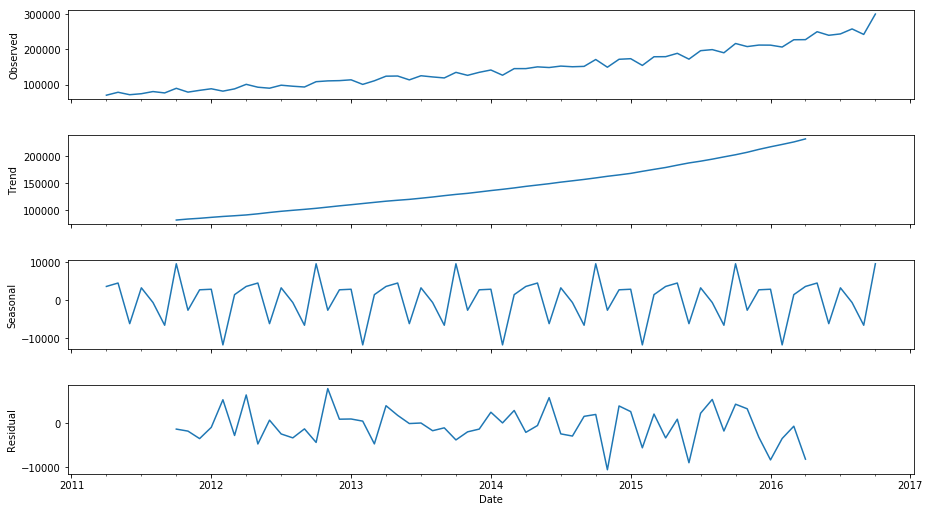

In [6]:
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

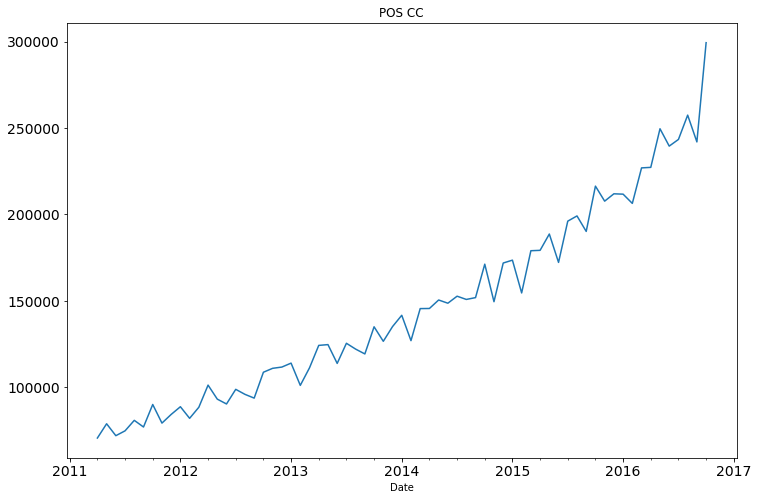

In [7]:
df3.pos_cc.plot(figsize=(12,8), title= 'POS CC', fontsize=14)

#### ARIMA modelling
* To find the right (pdq) and seasonal (pdq) model triplets that fit the pre-demonetization trend
    + RMSE & AIC values was calculated for the various pdq,seasonal-pdq combinations
    + RMSE was the least in the combination **(pdq) = (0, 0, 1)  seasonal-pdq = (1, 0, 0, 12)**
    + However AIC is least in **(pdq) = (1, 0, 1) seasonal-pdq = (1, 1, 1, 12)**
    + The Model was tried with both the options to go with the 2nd option

> Credit: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
>
> Code was customized to include RMSE to find the best fitting (p,d,q) & seasonal (p,d,q) triplets

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

results_pos_cc = pd.DataFrame(columns=['pdq', 'seasonal_pdq', 'aic', 'rmse'])

index_rad=0

p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df3['pos_cc'],
                                            order=param,trend='n',
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            df3['forecast_pos_cc'] = results.predict(start='2015-10-01',dynamic=True)  
            rmse = sqrt(mean_squared_error(df3['2015-10-01':]['pos_cc'], df3['2015-10-01':]['forecast_pos_cc']))
            print('ARIMA{}x{}12 - AIC:{} - RMSE:{}'.format(param, param_seasonal, results.aic,rmse))
            results_pos_cc.loc[index_rad] = [param,param_seasonal,results.aic,rmse]
            index_rad = index_rad+1
        except:
            print('Is this failing??')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1768.7399307468581 - RMSE:235157.46035943498
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:85722.36088072344 - RMSE:235933.6220276445
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1291.5118147979197 - RMSE:61271.000637824334
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1008.7374284094541 - RMSE:51888.66669045907
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1147.1813549702856 - RMSE:11353.28631118011
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1128.713076171923 - RMSE:11224.564741177803
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:933.0843777826534 - RMSE:15583.60783344458
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:915.4431307233879 - RMSE:15333.510568095435
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8594.303853873089 - RMSE:235309.3659092301
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1379.9814518638636 - RMSE:144372.07389644565
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1238.278331948475 - RMSE:57461.608690232926
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:958.2330645944309 - RMSE:47037.61414494982
ARIMA(0, 0, 1)x(1, 0, 0, 12)1

In [9]:
results_pos_cc = results_pos_cc.sort_values('rmse')
results_pos_cc.head(5)

,pdq,seasonal_pdq,aic,rmse
12,"(0, 0, 1)","(1, 0, 0, 12)",1528.056943,10391.227748
47,"(1, 0, 1)","(1, 1, 1, 12)",860.704859,10710.603251
45,"(1, 0, 1)","(1, 0, 1, 12)",1112.537798,11065.773349
37,"(1, 0, 0)","(1, 0, 1, 12)",1148.955757,11216.375464
5,"(0, 0, 0)","(1, 0, 1, 12)",1128.713076,11224.564741


In [10]:
mod = sm.tsa.statespace.SARIMAX(df3['pos_cc'],
                                order=(0, 0, 1),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

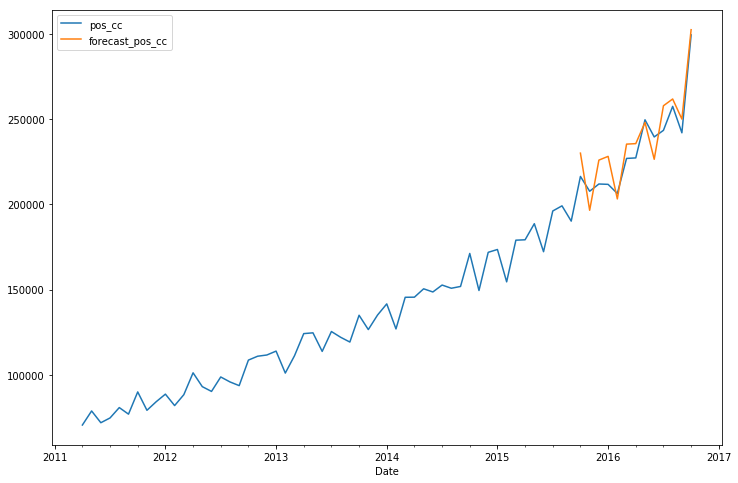

In [11]:
df3['forecast_pos_cc'] = results.predict(start='2015-10-01',end='2018-01-01',dynamic=True)  
df3[['pos_cc', 'forecast_pos_cc']].plot(figsize=(12, 8)) 

In [12]:
mod = sm.tsa.statespace.SARIMAX(df3['pos_cc'],
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

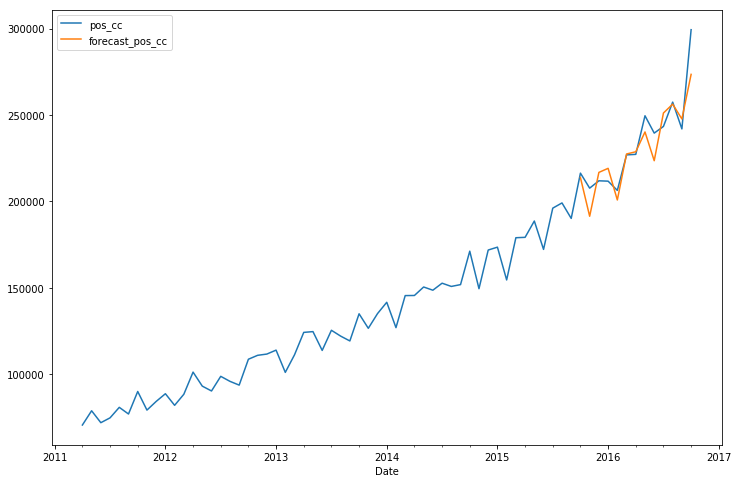

In [13]:
df3['forecast_pos_cc'] = results.predict(start='2015-10-01',end='2018-01-01',dynamic=True)  
df3[['pos_cc', 'forecast_pos_cc']].plot(figsize=(12, 8)) 

In [14]:
start = datetime.datetime.strptime("2016-10-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(1,18)]
future = pd.DataFrame(index=date_list, columns= df3.columns)
dates_list = [datex.date() for datex in date_list]
future['Date'] = dates_list
df4 = pd.concat([df3, future])

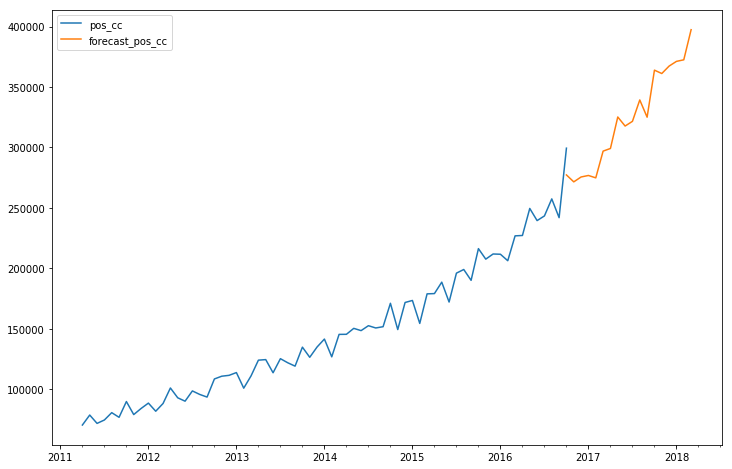

In [15]:
df4['forecast_pos_cc'] = results.predict(start = '2016-10-01', end = '2018-03-01', dynamic= True)  
df4[['pos_cc', 'forecast_pos_cc']].plot(figsize=(12, 8)) 

In [16]:
#df4.set_index(['Date'],inplace=True)
for index, row in df4.iterrows():
    #print(df4.loc[index,'forecast_atm_dc'])
    if np.isnan(df4.loc[index,'forecast_pos_cc']):
        df4.loc[index,'forecast_pos_cc'] = df4.loc[index,'pos_cc']

In [17]:
dfx=df2
#dfx.set_index(['Date'],inplace=True)

In [18]:
merge=pd.merge(df2,df4, how='inner', left_index=True, right_index=True)

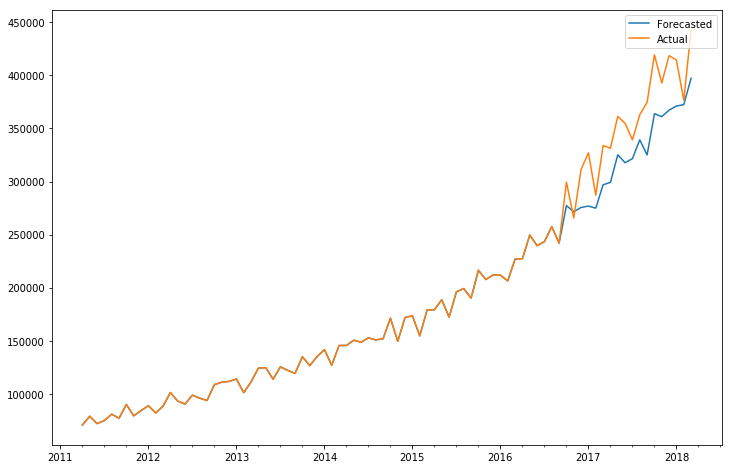

In [19]:
merge['forecast_pos_cc'].plot(figsize=(12, 8),label='Forecasted') 
merge['pos_cc_x'].plot(figsize=(12, 8),label='Actual') 
plt.legend(loc='upper right')
plt.show()


In [20]:
merge['diff'] = merge['pos_cc_x'] - merge['forecast_pos_cc']
merge[merge['diff']!=0]['diff']

2016-10-01    22120.096963
2016-11-01    -5976.053957
2016-12-01    35877.422997
2017-01-01    50227.184670
2017-02-01    12156.835670
2017-03-01    36921.779736
2017-04-01    32250.090601
2017-05-01    36210.562822
2017-06-01    37120.061710
2017-07-01    17696.252870
2017-08-01    23698.410961
2017-09-01    49621.600438
2017-10-01    55469.186121
2017-11-01    31832.990306
2017-12-01    51352.822047
2018-01-01    43200.661755
2018-02-01     4136.637795
2018-03-01    45713.466794
Name: diff, dtype: float64

In [21]:
merge[merge['diff']!=0]['diff'].mean()

32201.66723869538